In [11]:
import numpy as np
import scipy as sp
import json
from PIL import Image
from matplotlib import pyplot as plt
from scipy.misc import imresize



ModuleNotFoundError: No module named 'numpy'

In [3]:
import json
import os

def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

def save_json(data, file_path):
    with open(file_path, 'w') as f:
        json.dump(data, f, indent=4)

def combine_labelme_json(files):
    combined_data = {
        "images": [],
        "annotations": []
    }

    for idx, file in enumerate(files):
        data = load_json(file)
        
        # Adding unique image_id and annotation_id to avoid conflicts
        image_id = idx + 1
        for shape in data['shapes']:
            shape['image_id'] = image_id

        combined_data["images"].append({
            "image_id": image_id,
            "file_name": data["imagePath"],
            "height": data["imageHeight"],
            "width": data["imageWidth"]
        })

        combined_data["annotations"].extend(data['shapes'])

    return combined_data

# List of JSON files to be combined

path = "img/test/"
json_filenames = ["frame29.json", "frame32.json","frame52.json","frame56.json","frame62.json","frame64.json","frame82.json"]
json_files = [os.path.join(path, filename) for filename in json_filenames]


# Combine the JSON files
combined_json = combine_labelme_json(json_files)

# Save the combined JSON to a new file
save_json(combined_json, "train_ds.json")

print("JSON files combined successfully!")


JSON files combined successfully!


In [16]:
import json
import os

# Define the path and the list of JSON filenames
path = "img/test/"
json_filenames = ["frame29.json", "frame32.json", "frame52.json", "frame56.json", "frame62.json", "frame64.json", "frame82.json"]
json_files = [os.path.join(path, filename) for filename in json_filenames]

# Initialize the final output format
final_output = {
    'files': []
}

# Iterate over each JSON file in the provided list
for json_file in json_files:
    with open(json_file, 'r') as f:
        input_json = json.load(f)
    
    # Initialize the output format for each file
    output_json = {
        'filename': input_json['imagePath'],
        'boxes': []
    }
    
    # Convert shapes to the desired format
    for shape in input_json['shapes']:
        label = float(shape['label'])
        left = shape['points'][0][0]
        top = shape['points'][0][1]
        right = shape['points'][1][0]
        bottom = shape['points'][1][1]
        width = right - left
        height = bottom - top
        
        box = {
            'height': height,
            'label': label,
            'left': left,
            'top': top,
            'width': width
        }
        output_json['boxes'].append(box)
    
    # Append the output_json to the final_output
    final_output['files'].append(output_json)

# Save the final merged output to a new JSON file
output_file = 'merged.json'
with open(output_file, 'w') as f:
    json.dump(final_output, f, indent=2)

print(f"Merged JSON file saved as {output_file}")


Merged JSON file saved as merged.json


In [19]:
TRAIN_PATH = 'img/test/'
TRAIN_DIGITSTRUCT = 'img/test/train_ds.json'
DIGIT_RATIO = 24./32

In [21]:
with open(TRAIN_DIGITSTRUCT, 'r') as f:
    train_ds = json.load(f)
print(len(train_ds))
print(len(train_ds['files']))



1
7


In [22]:

sample = train_ds['files'][1]
sample

{'filename': 'frame32.jpg',
 'boxes': [{'height': 33.333333333333314,
   'label': 1.0,
   'left': 483.8596491228071,
   'top': 263.9473684210526,
   'width': 16.66666666666663},
  {'height': 35.96491228070175,
   'label': 9.0,
   'left': 504.0350877192983,
   'top': 263.9473684210526,
   'width': 22.80701754385973},
  {'height': 32.456140350877206,
   'label': 8.0,
   'left': 529.4736842105264,
   'top': 267.45614035087715,
   'width': 18.42105263157896},
  {'height': 28.070175438596493,
   'label': 9.0,
   'left': 552.2807017543861,
   'top': 267.45614035087715,
   'width': 21.052631578947285},
  {'height': 35.087719298245645,
   'label': 1.0,
   'left': 576.842105263158,
   'top': 265.7017543859649,
   'width': 18.421052631578846}]}

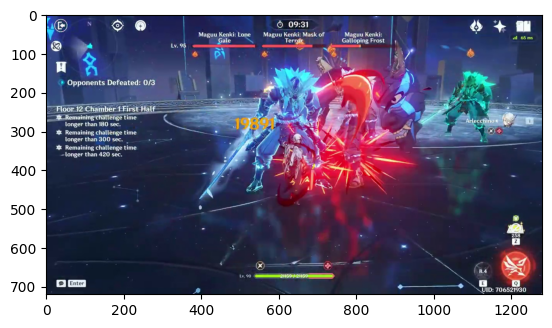

In [23]:
im = np.array(Image.open(TRAIN_PATH + sample['filename']))
plt.imshow(im)

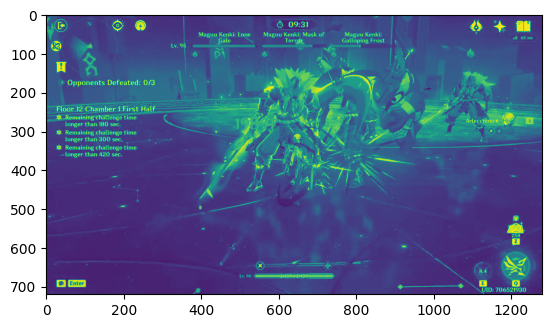

In [27]:
im = np.array(Image.open(TRAIN_PATH + sample['filename']).convert('L'))
plt.imshow(im)

In [24]:
def preprocess(img):
    try:
        img = imresize(img, (32, 24))
        img = img.astype(np.float32) / np.max(img)
    except:
        return None
    return img

In [39]:
def preprocess(img):
    try:
        img = imresize(img, (32, 24))
        img = img.astype(np.float32) / np.max(img)
    except:
        return None
    return img

def gen_cuts(image, boxes):
    cuts = []
    labels = []
    
    number_left = image.shape[1]
    number_right = 0
    number_top = image.shape[0]
    number_bottom = 0
    
    na_w = 0
    na_h = 0
    
    for box in boxes:
        middle = int(box['left'] + box['width'] / 2)
        height = int(box['height'])
        width = int(height * DIGIT_RATIO)
        left = int(middle - width/2)
        right = left + width
        top = int(box['top'])
        bottom = top + height
        
        if left < number_left: number_left = left
        if right > number_right: number_right = right
        if top < number_top: number_top = top
        if bottom > number_bottom: number_bottom = bottom
        if na_w == 0: na_w = width
        if na_h == 0: na_h = height
        
        cut = im[top:bottom, left:right]
        cut = preprocess(cut)
        
        if cut is None:
            continue
        
        cuts.append(cut)
        label = box['label'] if box['label'] != 10 else 0
        labels.append(int(label))
    
    for left in range(0, image.shape[1]-na_w, na_w):
        if (left+na_w < number_left) or (left > number_right):
            cut = im[0:na_h, left:left+na_w]
            cut = preprocess(cut)

            if cut is None:
                continue
            cuts.append(cut)
            labels.append(10)
    

    return cuts, labels


In [41]:
all_cuts = []
all_labels = []
for i, sample in enumerate(train_ds['files']):
    if i % 1000 == 0: print(i)

    im = np.array(Image.open(TRAIN_PATH + sample['filename']).convert('L'))
    img_cuts, img_labels = gen_cuts(im, sample['boxes'])
    all_cuts.extend(img_cuts)
    all_labels.extend(img_labels)

print("{} cuts total".format(len(all_labels)))
print('done!')


0
0 cuts total
done!


In [ ]:
plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, cut in enumerate(all_cuts[:10]):
    ax[i].axis('off')
    ax[i].imshow(cut, cmap='gray')
    ax[i].set_title(all_labels[i], loc='center')

In [54]:
import json
import cv2
import numpy as np
import os

# Load the merged JSON file
with open('img/test/train_ds.json', 'r') as f:
    train_ds = json.load(f)

# Function to crop and preprocess the digit images
def preprocess_data(train_ds, base_path):
    images = []
    labels = []
    
    for item in train_ds['files']:
        img_path = os.path.join(base_path, item['filename'])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        for box in item['boxes']:
            left = int(box['left'])
            top = int(box['top'])
            width = int(box['width'])
            height = int(box['height'])
            label = int(box['label'])
            
            # Ensure the label is within the expected range
            if 0 <= label <= 9:
                # Crop the image
                cropped_img = img[top:top + height, left:left + width]
                resized_img = cv2.resize(cropped_img, (28, 28))  # Resize to 28x28 pixels
                images.append(resized_img)
                labels.append(label)
    
    images = np.array(images).reshape(-1, 28, 28, 1)  # Reshape for model input
    labels = np.array(labels)
    
    return images, labels

# Base path to the images
base_path = 'img/test'
images, labels = preprocess_data(train_ds, base_path)


In [ ]:
# Print the length of the dataset
print(f"Number of samples: {len(images)}")

# Visualize one of the samples (for example, the first one)
sample_index = 30
sample_image = images[sample_index].reshape(28, 28)  # Reshape for visualization
sample_label = labels[sample_index]

plt.imshow(sample_image, cmap='gray')
plt.title(f"Label: {sample_label}")
plt.show()


Number of samples: 42


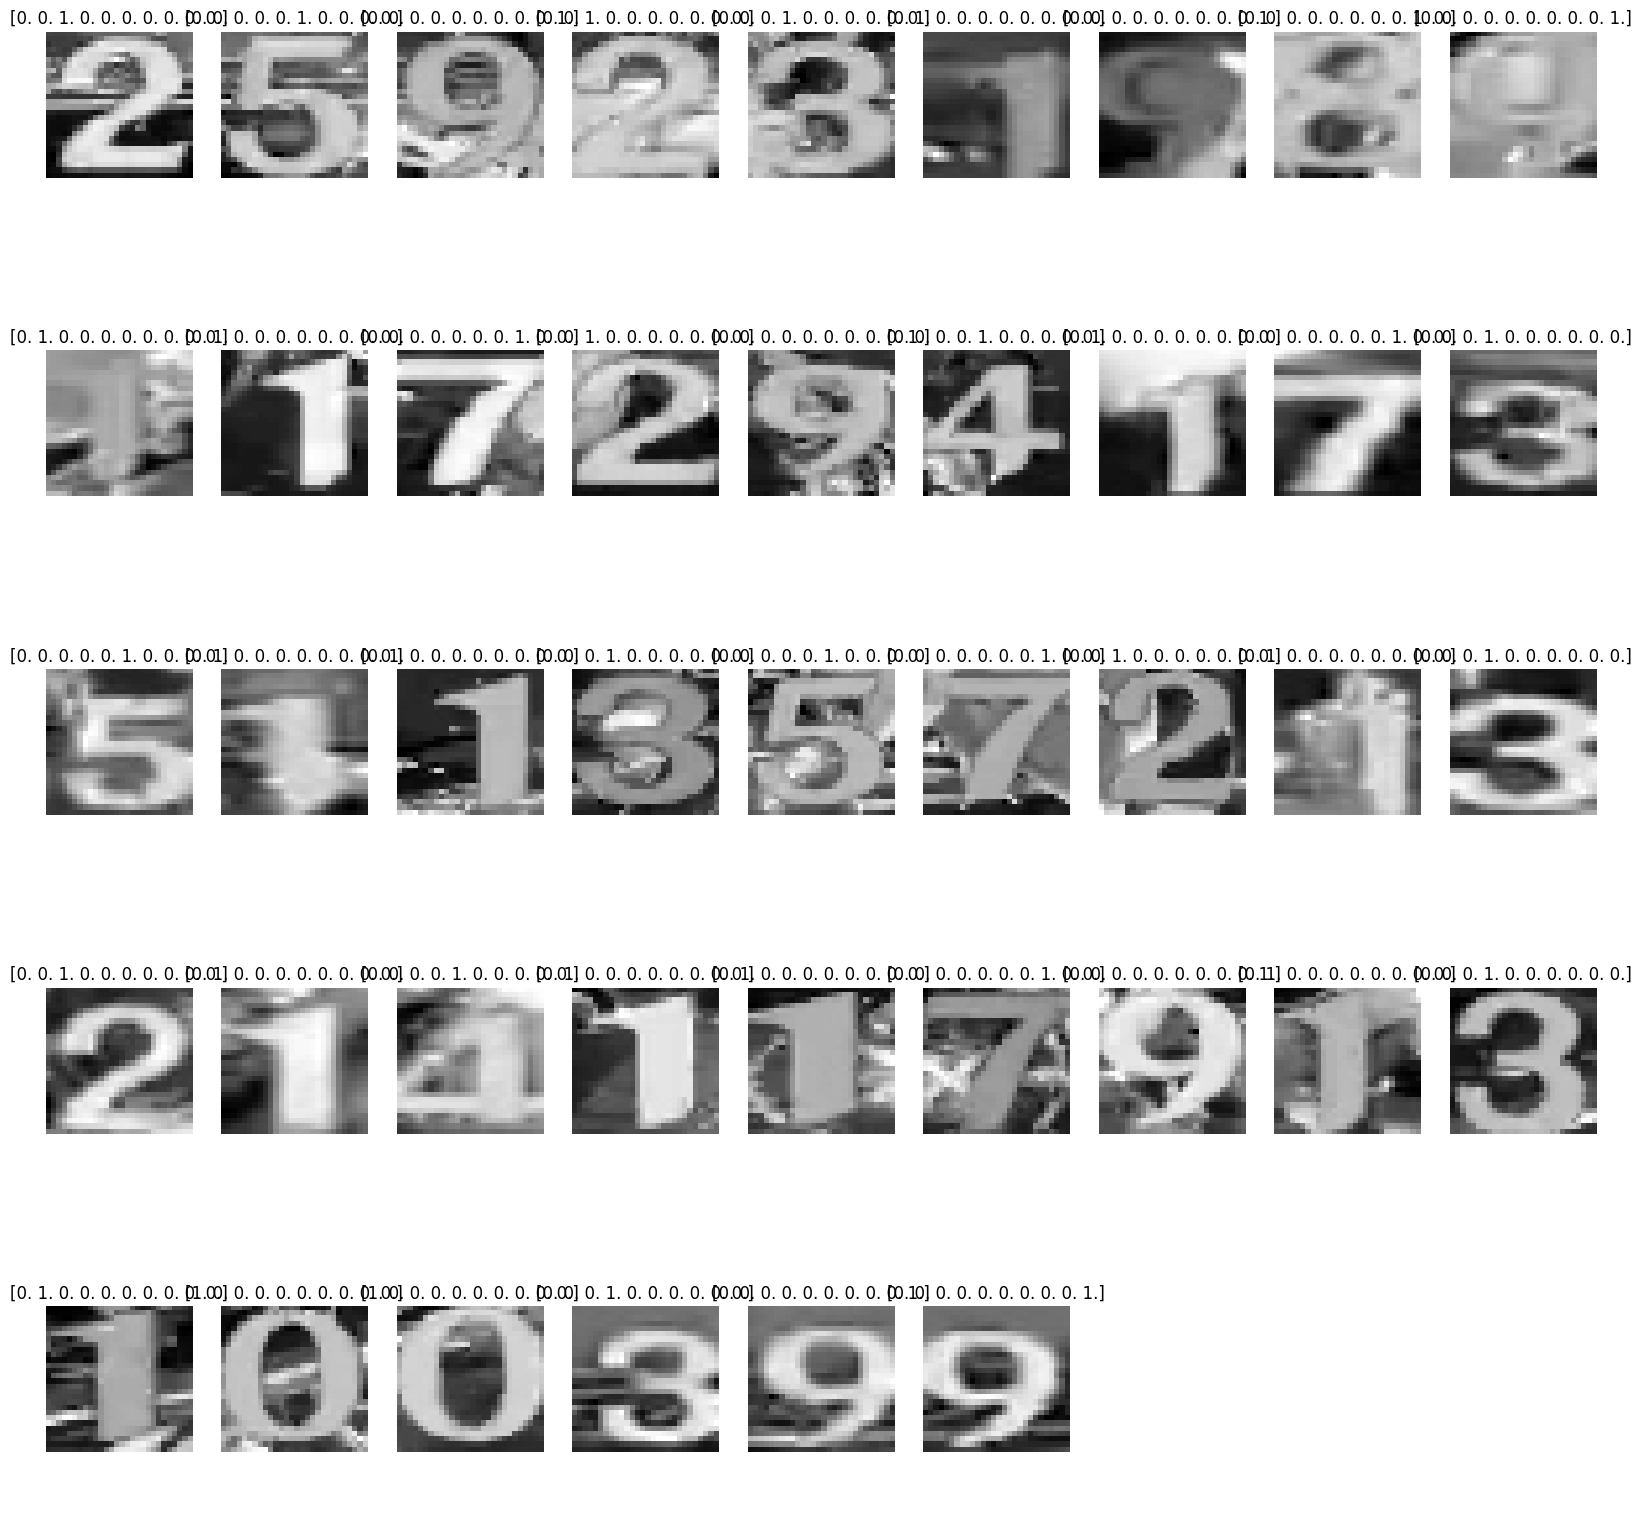

In [61]:
# Print the length of the dataset
print(f"Number of samples: {len(images)}")

# Visualization: Display all samples in a 5x9 grid
plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=5, ncols=9)

# Display the first 45 samples (or fewer if less than 45 samples exist)
for i in range(5):
    for j in range(9):
        index = i * 9 + j
        if index < len(images):
            sample_image = images[index].reshape(28, 28)  # Reshape for visualization
            sample_label = labels[index]
            ax[i, j].axis('off')
            ax[i, j].imshow(sample_image, cmap='gray')
            ax[i, j].set_title(sample_label, loc='center')
            #ax[i, j].set_title(int(sample_label), loc='center')
        else:
            ax[i, j].axis('off')  # Hide axis if there are no more samples to display

plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Normalize the images
images = images / 255.0

# One-hot encode the labels
labels = to_categorical(labels, num_classes=10)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [57]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


c:\Users\zuhair.aziz\Desktop\python\damageTracker_project\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 619ms/step - accuracy: 0.1531 - loss: 2.3013 - val_accuracy: 0.3333 - val_loss: 2.2064
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.2756 - loss: 2.1974 - val_accuracy: 0.3333 - val_loss: 2.1516
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.2756 - loss: 2.1201 - val_accuracy: 0.3333 - val_loss: 2.1604
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2652 - loss: 2.0782 - val_accuracy: 0.3333 - val_loss: 2.2031
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.2756 - loss: 2.0592 - val_accuracy: 0.3333 - val_loss: 2.2271
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.2756 - loss: 2.0711 - val_accuracy: 0.3333 - val_loss: 2.2534
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.2756 - loss: 2.0569 - val_accuracy: 0.3333 - val_loss: 2.2795
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.4182 - loss: 2.0777 - val_accuracy: 0.0000e+00 - val_loss: 2.

In [58]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.0000e+00 - loss: 2.3347
Test accuracy: 0.0
